In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import mal_cfr_data.plot as mcd_plt
import mal_cfr_data.tournament as mcd_tournament

mcd_plt.set_plt_params()
div_color_palette = mcd_plt.diverging_color_palette()
seq_color_palette = mcd_plt.sequential_color_palette()

/Users/morrill/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
data = mcd_tournament.Data.load()
data.data

,game_tag,sampler,seed,mode,row_alg,col_alg,value,t
0,goofspiel_3p,null,None,fixed,CFR,CFR,-2.312960e-18,0
1,goofspiel_3p,null,None,fixed,CFR,CFR_EX+IN,-2.312960e-18,0
2,goofspiel_3p,null,None,fixed,CFR,CFR_IN,-2.312960e-18,0
3,goofspiel_3p,null,None,fixed,CFR,A-CFR_IN,-2.312960e-18,0
4,goofspiel_3p,null,None,fixed,CFR,BPS-CFR,-2.312960e-18,0
...,...,...,...,...,...,...,...,...
671995,tiny_hanabi,null,None,fixed,BR,TIPS-CFR,9.000000e+00,399
671996,tiny_hanabi,null,None,fixed,BR,CSPS-CFR,9.000000e+00,399
671997,tiny_hanabi,null,None,fixed,BR,CFPS-CFR,9.000000e+00,399
671998,tiny_hanabi,null,None,fixed,BR,CFPS-CFR_EX+IN,8.000000e+00,399


In [6]:
alg_comparisons = (
    ('CFR', 'CFR_IN', 'CFPS-CFR', 'TIPS-CFR'),  # CFR vs. level 1 vs. level 2 vs. level 3
    ('CFR', 'A-CFR_IN', 'CFR_IN', 'CFR_EX+IN'),  # Level 1 algorithms
    ("BPS-CFR", "CFPS-CFR", "CFPS-CFR_EX+IN"),  # Level 2 algorithms
    ("CSPS-CFR", "TIPS-CFR", "TIPS-CFR_EX+IN"),  # Level 3 algorithms
)
all_algs = set()
for alg_group in alg_comparisons:
    all_algs = all_algs.union({alg for alg in alg_group})
print(all_algs)

# Setup algorithm specific colors
line_graph_colors = sns.color_palette('tab10')
sorted_algs = sorted(all_algs, key=mcd_tournament.alg_sort_key)
alg_color = {
    alg: line_graph_colors[i] for i, alg in enumerate(sorted_algs)
}

learning_curve_query_string = 'game_tag == "{game}" & mode == "{mode}"\
    & col_alg == {col_algs}\
    & row_alg == {algs}'

data.data = data.data.query(f'col_alg == {list(all_algs)} & row_alg == {list(all_algs)}')

ylim_by_game = {
    'tiny_bridge': (19.6, 20.7),
    'tiny_hanabi': (7.5, 8.7),
}

def sharex_and_y_in_row(axes_list):
    for j, ax in enumerate(axes_list[1:]):
        axes_list[j - 1].sharex(ax)
        axes_list[j - 1].sharey(ax)
        
def sharex_in_row(axes_list):
    for j, ax in enumerate(axes_list[1:]):
        axes_list[j - 1].sharex(ax)

{'CFPS-CFR_EX+IN', 'CFPS-CFR', 'TIPS-CFR', 'CFR_IN', 'CFR', 'CSPS-CFR', 'BPS-CFR', 'A-CFR_IN', 'CFR_EX+IN', 'TIPS-CFR_EX+IN'}


In [7]:
def learning_curve_data(df):
    df = df.pivot(index=['col_alg', 'row_alg'], columns='t', values='value')
    df = df.cumsum(axis=1)
    return (df.mean(level=1) / (df.columns.to_numpy() + 1)).T.sort_index(axis=1, key=mcd_tournament.alg_sort_keys)

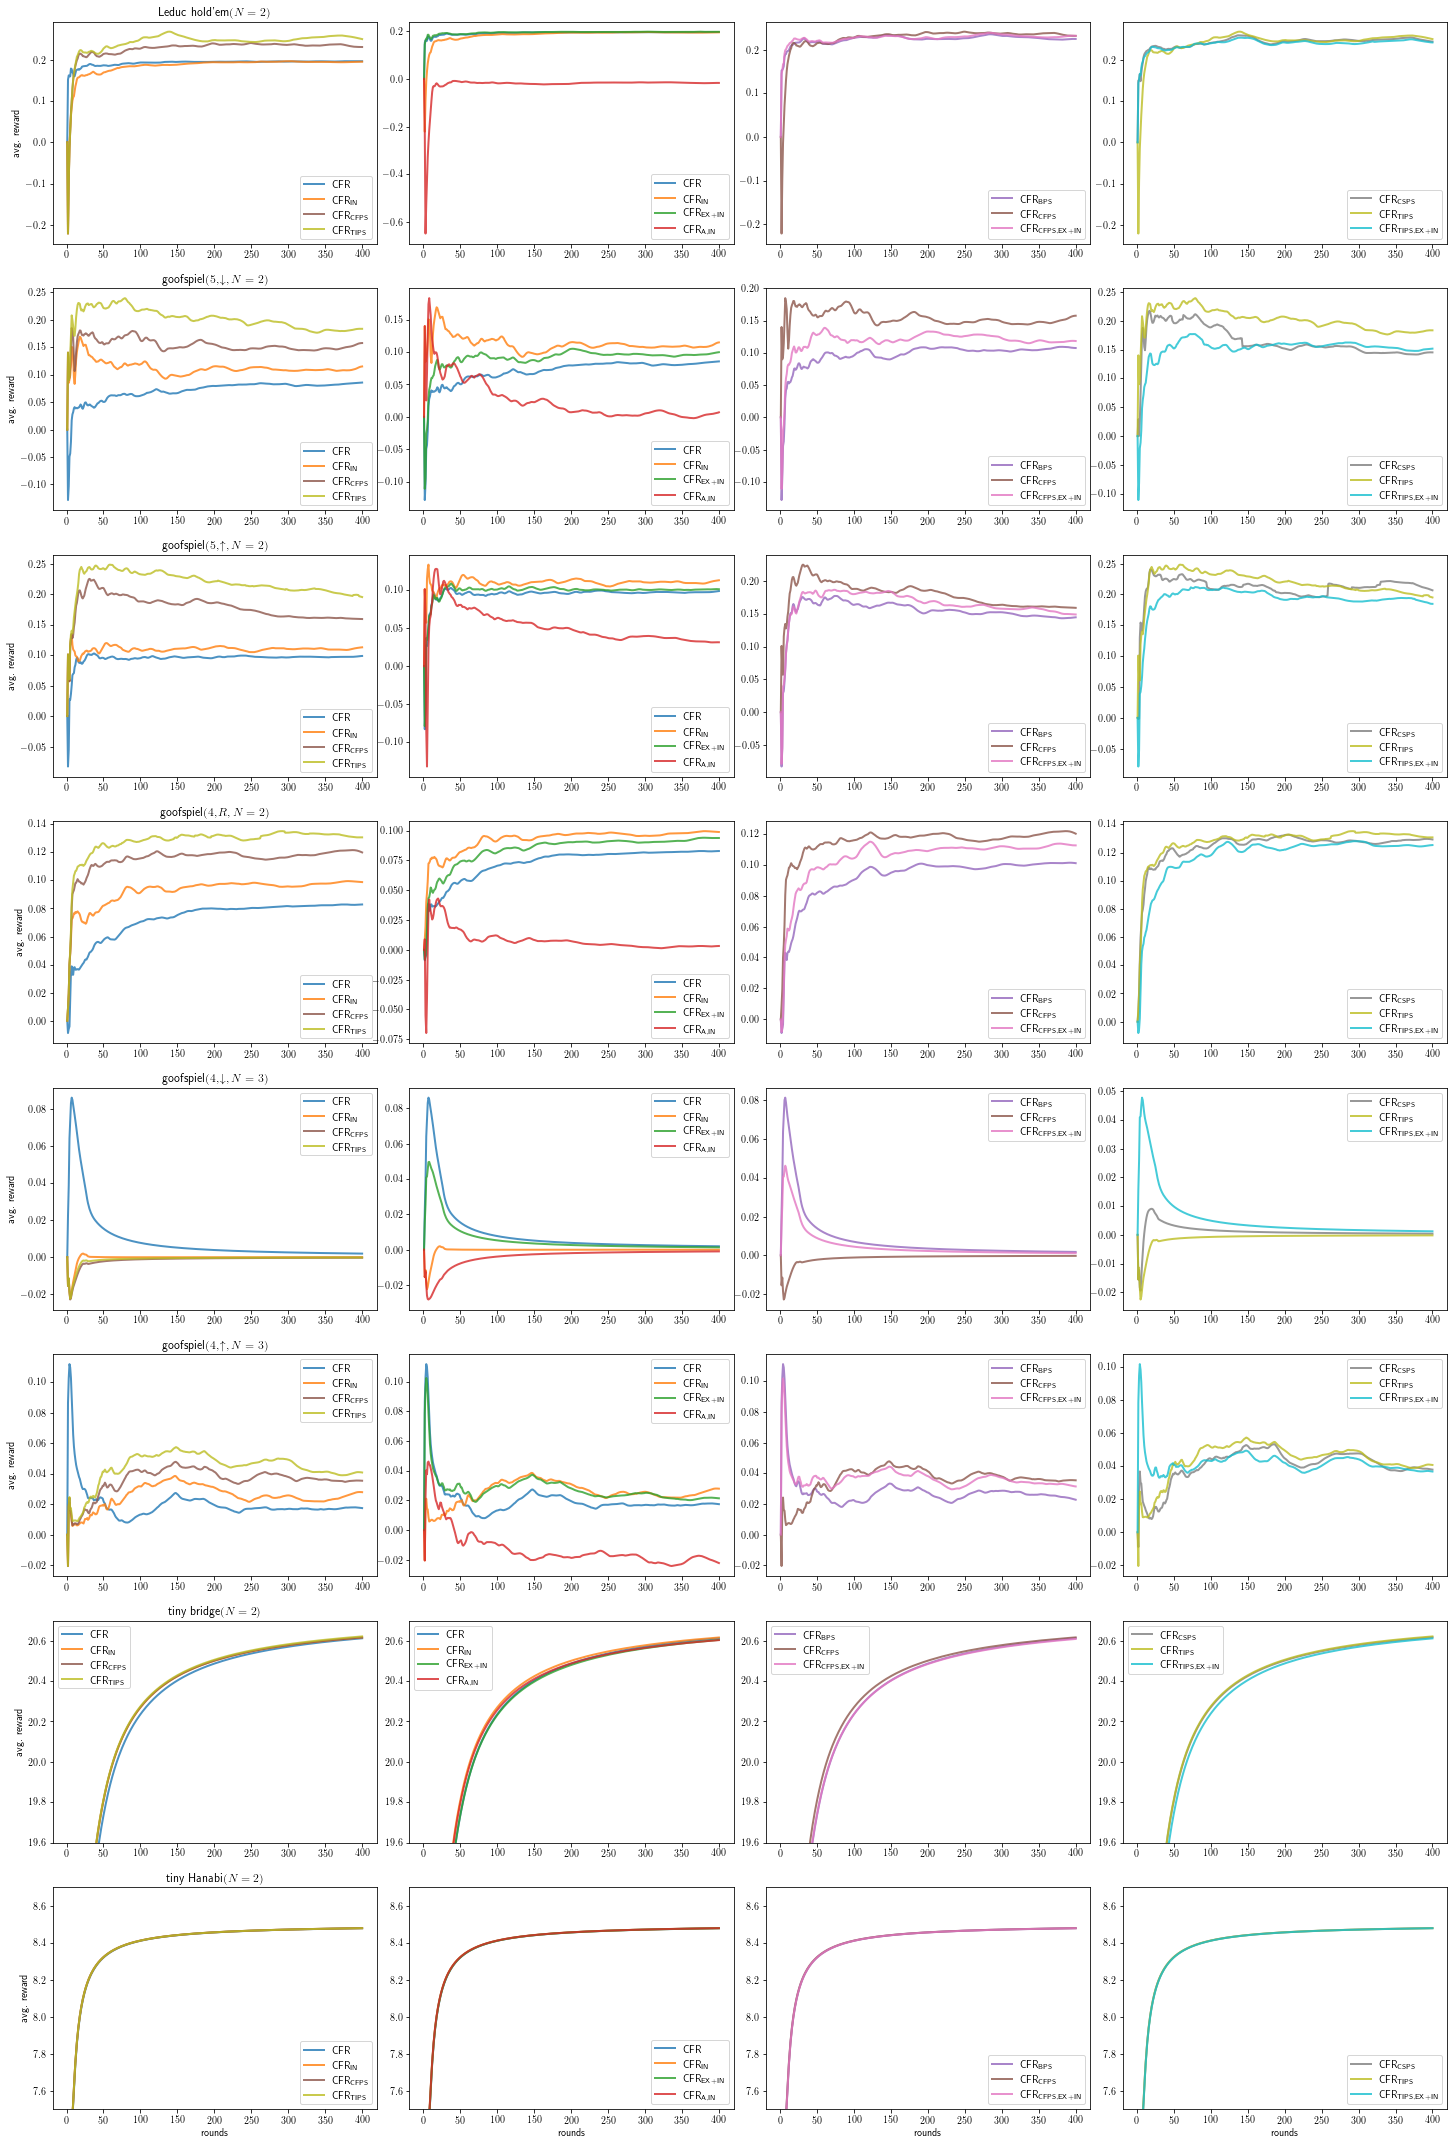

In [10]:
fig, axes_list = plt.subplots(
    len(data.games()),
    len(alg_comparisons),
    squeeze=False,
#     sharex=True,
#     sharey=False,
    figsize=(5 * len(alg_comparisons), 3.7 * len(data.games())),
#     gridspec_kw={'width_ratios': [0.25, 1, 1]}
)
for i, game_tag in enumerate(sorted(data.games(), key=mcd_tournament.game_sort_key)):
    sharex_in_row(axes_list[i, :])
    for j, alg_group in enumerate(alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='fixed',
                    algs=alg_group,
#                     col_algs=alg_group)
                    col_algs=list(all_algs))
            ))
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        ax.legend()
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
    axes_list[i, 0].set_ylabel('avg. reward')
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.savefig('results/learning_curves.fixed.oct10_2020.pdf')

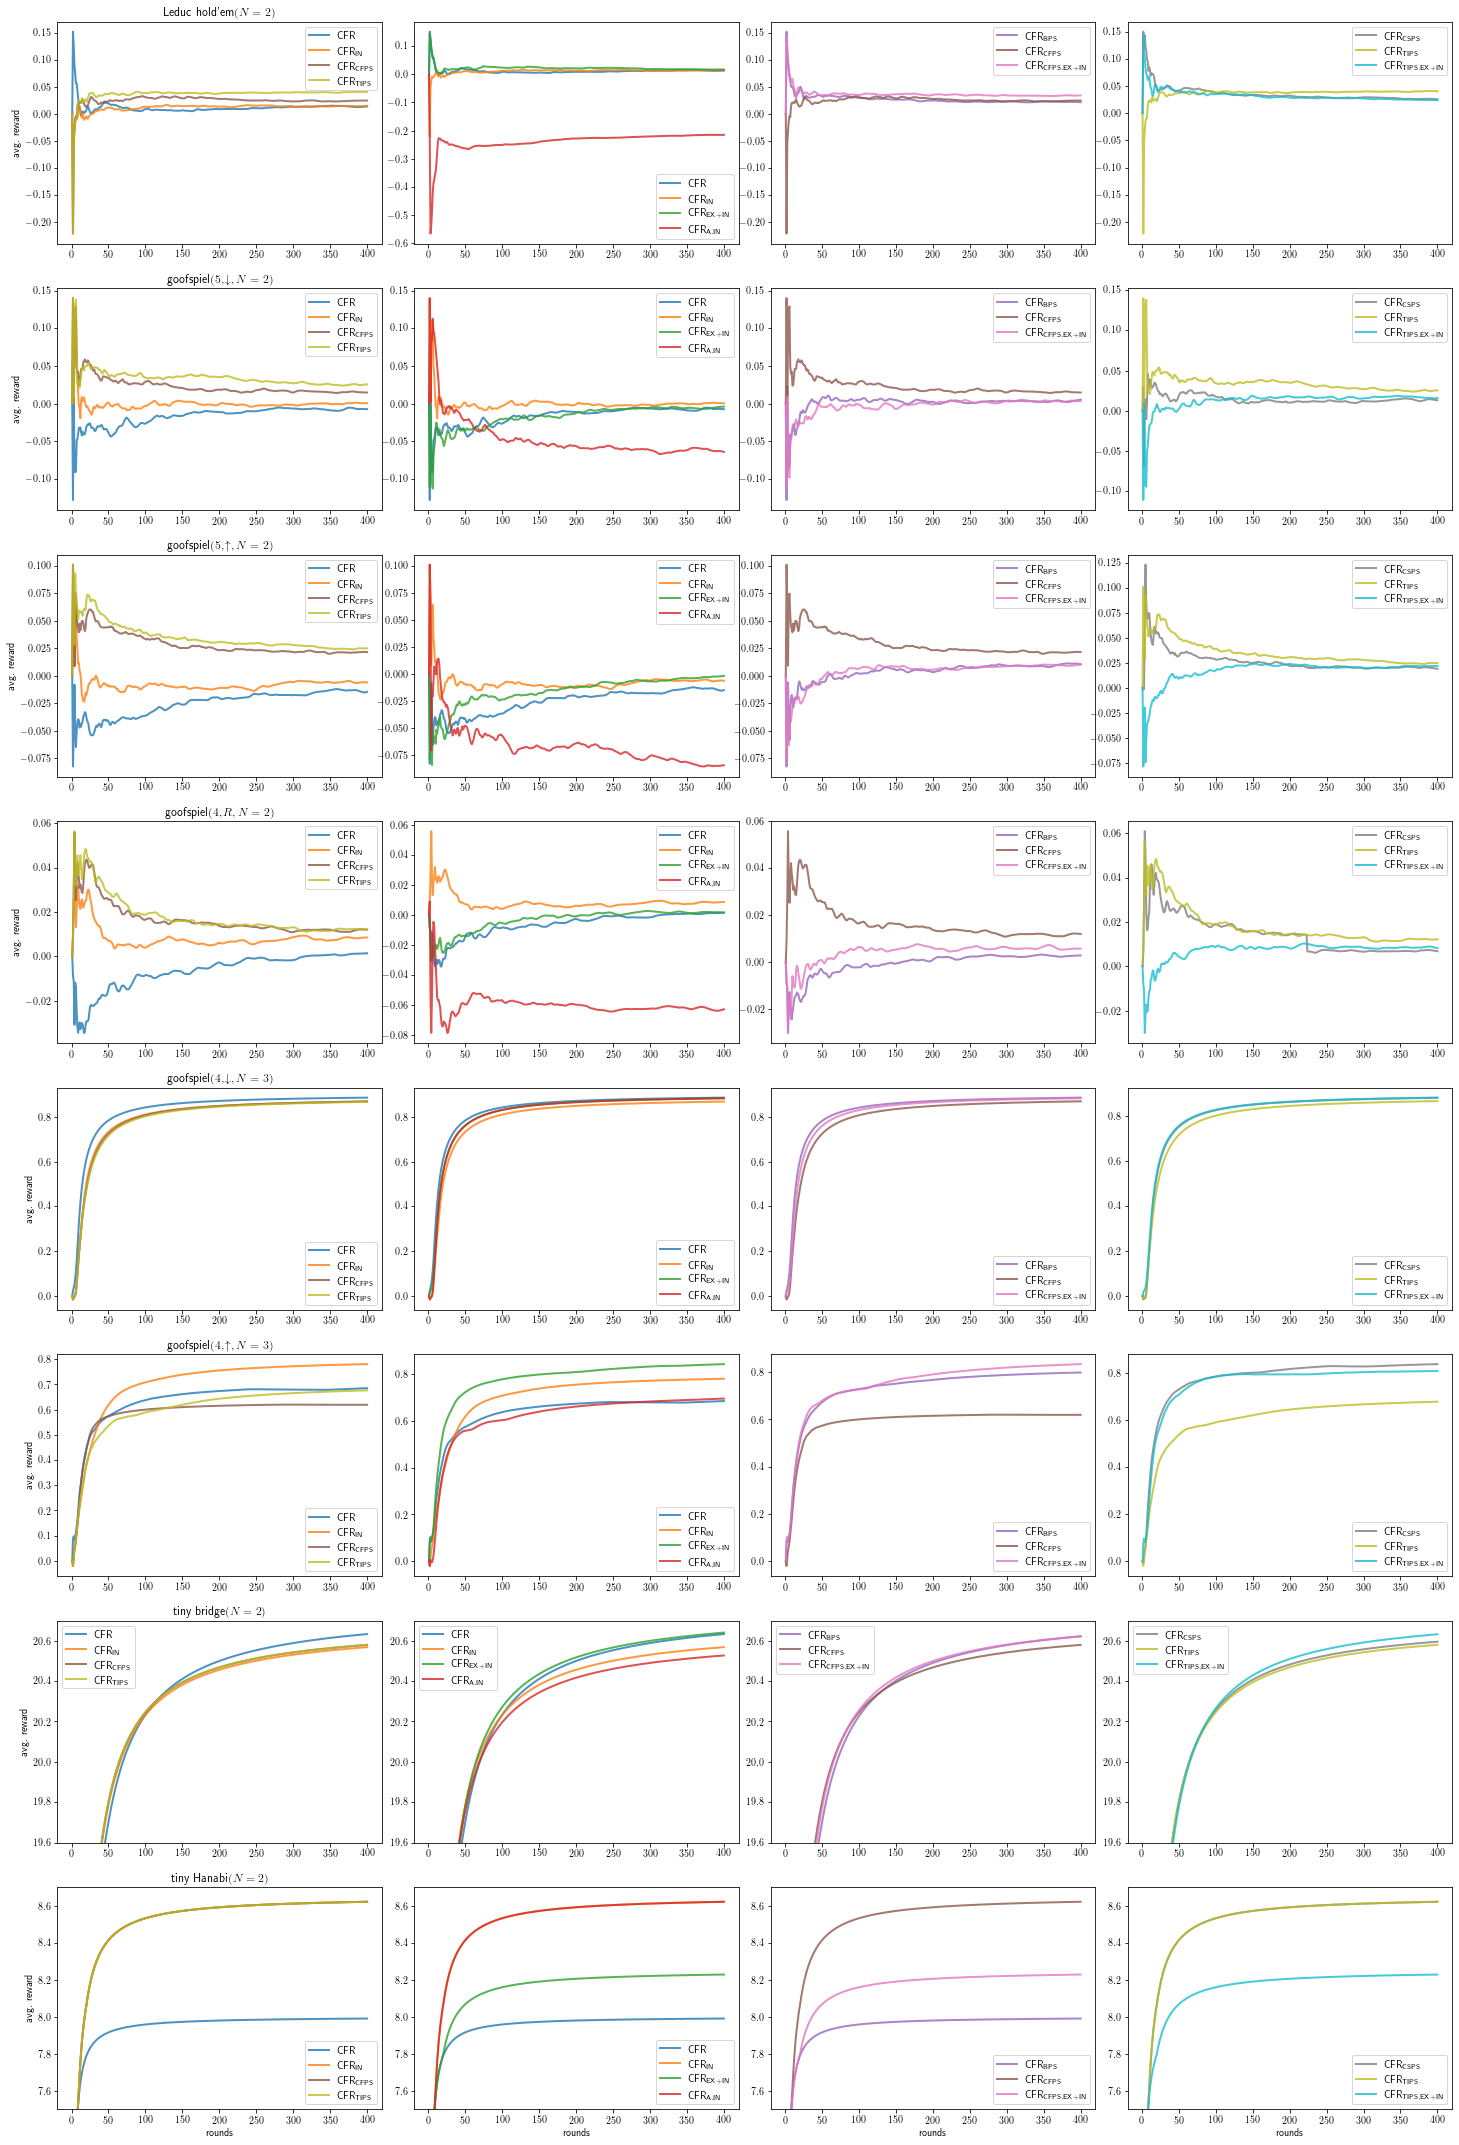

In [11]:
fig, axes_list = plt.subplots(
    len(data.games()),
    len(alg_comparisons),
    squeeze=False,
    figsize=(5 * len(alg_comparisons), 3.7 * len(data.games())),
#     gridspec_kw={'width_ratios': [0.25, 1, 1]}
)

for i, game_tag in enumerate(sorted(data.games(), key=mcd_tournament.game_sort_key)):
    sharex_in_row(axes_list[i, :])
    for j, alg_group in enumerate(alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='sim',
                    algs=alg_group,
#                     col_algs=alg_group)
                    col_algs=list(all_algs))
            ))
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        ax.legend()
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
    axes_list[i, 0].set_ylabel('avg. reward')
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.savefig('results/learning_curves.sim.oct10_2020.pdf')

In [ ]:
# plt.figure(figsize=(10, 3))
# mcd_tournament.heatmap(
#     mcd_tournament.without_br_row(data.fixed_table('kuhn_3p')),
#     cmap=div_color_palette
# )

In [ ]:
# for seed in data.all_seeds():
#     if not np.isnan(seed):
#         plt.figure(figsize=(10, 3))
#         mcd_tournament.heatmap(
#             mcd_tournament.without_br_row(
#                 data.shuffled_table('kuhn_3p', seed)) * 1000,
#             cmap=div_color_palette)
#         plt.show()

In [ ]:
# (data.shuffled_table_by_seed("kuhn_3p") * 1000).std().max()

In [ ]:
# (data.max_abs_diff_from_mean("kuhn_3p") * 1000).max()

In [ ]:
# _df = data.time_avg_sim_table('tiny_hanabi', 200).query('row_alg == ["CFR", "FP"] & col_alg == ["CFR"]')

In [ ]:
num_cols = 2
fig, axes_list = plt.subplots(
    len(data.games()),
    num_cols + 1,
    squeeze=False,
    figsize=(21, 3.7 * len(data.games())),
    gridspec_kw={'width_ratios': [0.25, 1, 1]})
axes_list[0, 1].set_title('fixed compatriots')
axes_list[0, 2].set_title('learning compatriots')

num_rounds = 200
for i, game in enumerate(data.games()):
    axes_list[i, 2].sharex(axes_list[i, 1])
    axes_list[i, 2].sharey(axes_list[i, 1])
#     axes_list[i, 2].yaxis.set_visible(False)

    print(game)
    
    scale = 1000 if (
        game == 'kuhn_3p'
        or game == 'leduc'
        or game == 'kuhn_4p') else 1
    if (game == 'goofspiel'
        or game == 'random_goofspiel'
        or game == 'tiny_bridge'
        or game == 'goofspiel_3p'):
        fmt = "0.2f"
    elif game == 'kuhn_3p':
        fmt = "0.3f"
    else:
        fmt = "0.1f"
    
    mcd_tournament.heatmap(
        mcd_tournament.without_br_row(data.time_avg_fixed_table(game, num_rounds)) * scale,
        fmt=fmt,
        ax=axes_list[i, 1],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
#     mcd_tournament.heatmap(
#         mcd_tournament.without_br_row(data.avg_shuffled_table(game)) * scale,
#         fmt=fmt,
#         ax=axes_list[i, 1],
#         cmap=div_color_palette,
#         cbar_kws={'fraction': 0.05, 'pad': 0.01})
    mcd_tournament.heatmap(
        data.time_avg_sim_table(game, num_rounds) * scale,
        fmt=fmt,
        ax=axes_list[i, 2],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    axes_list[i, 0].axis('off')
    axes_list[i, 0].text(0, 0.5, mcd_tournament.game_label(game, num_rounds),
                         horizontalalignment='left',
                         verticalalignment='center',
                         transform=axes_list[i, 0].transAxes)
    
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.22, hspace=0.1)
fig.savefig(f'results/heatmaps.oct10_2020.pdf')
plt.show()

In [ ]:
# fig, axes_list = plt.subplots(
#     2,
#     1,
#     sharex=True,
#     sharey=True,
#     squeeze=True,
#     figsize=(13.5, 3.5 * 3))
# mcd_tournament.heatmap_avg(
#     mcd_tournament.without_br_row(data.fixed_avg_table()),
#     ax=axes_list[0],
#     cmap=div_color_palette,
#     cbar_kws={'fraction': 0.05, 'pad': 0.01},
#     fmt="0.3f"
# )
# # mcd_tournament.heatmap_avg(
# #     mcd_tournament.without_br_row(data.shuffled_avg_table()),
# #     ax=axes_list[1],
# #     cmap=div_color_palette,
# #     cbar_kws={'fraction': 0.05, 'pad': 0.01},
# #     fmt="0.3f"
# # )
# mcd_tournament.heatmap_avg(
#     mcd_tournament.without_br_row(data.sim_avg_table()),
#     ax=axes_list[1],
#     cmap=div_color_palette,
#     cbar_kws={'fraction': 0.05, 'pad': 0.01},
#     fmt="0.3f"
# )
# plt.tight_layout(0)
# plt.subplots_adjust(hspace=0.25)
# fig.savefig(f'results/avg_heatmaps.aug22_2020.pdf')
# plt.show()